# Convolutional Neural Networks

Convolutional neural networks (CNNs) are a type of artificial neural network that are commonly used for image and video processing, but can also be used for other types of data.

CNNs are designed to recognize patterns and features in images by using a series of convolutional layers that apply filters or kernels to the input data. Each filter detects a specific feature in the image, such as edges or corners, and the output of the convolutional layer is a feature map that highlights the locations of those features in the input image.

In addition to convolutional layers, CNNs also typically include pooling layers, which reduce the size of the feature maps by aggregating the information in adjacent regions. This helps to reduce the computational cost of the network and improve its ability to generalize to new images.

The final layers of a CNN are typically fully connected layers, which are similar to those used in traditional feedforward neural networks. These layers take the flattened feature maps from the previous layers and use them to make predictions about the class or category of the input image.

Training a CNN involves using backpropagation to adjust the weights of the network so that it can accurately classify images. This typically involves using a large dataset of labeled images to train the network and optimize its performance.

### Objective: Build a Convolutional Neural Network (CNNs) that given an image of a hand showing one of the letters A-I (Sign Language), detects which letter is being represented.

We will explore several convolutional architectures.

### I. DATA EXPLORATION

[American Sign Language (ASL)](https://en.wikipedia.org/wiki/American_Sign_Language)
is a complete, complex language that employs signs made by 
moving the hands combined with facial expressions and postures of the body. 
It is the primary language of many North Americans who are deaf and is one of several 
communication options used by people who are deaf or hard-of-hearing.

In [1]:
import numpy as np
import torchvision.models, torchvision.datasets

The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

[https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

In [2]:
train_path = "asl_data/train/"
valid_path = "asl_data/valid/"
test_path = "asl_data/test/"

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

We can iterate through the training data one data point at a time:

In [66]:
import matplotlib.pyplot as plt

torch.Size([3, 224, 224])
0


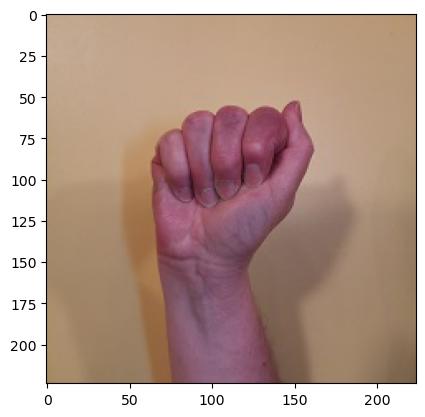

torch.Size([3, 224, 224])
0


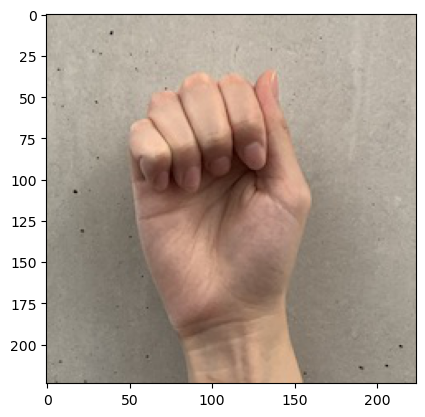

torch.Size([3, 224, 224])
1


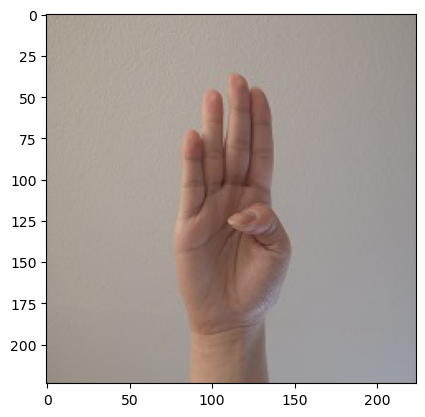

torch.Size([3, 224, 224])
1


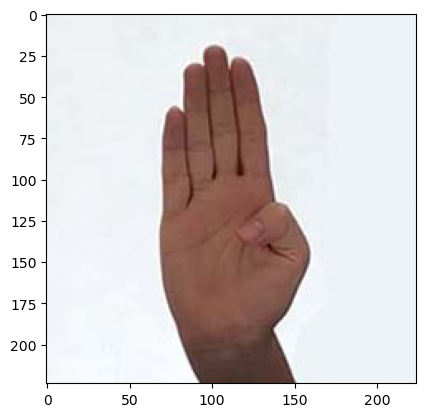

torch.Size([3, 224, 224])
2


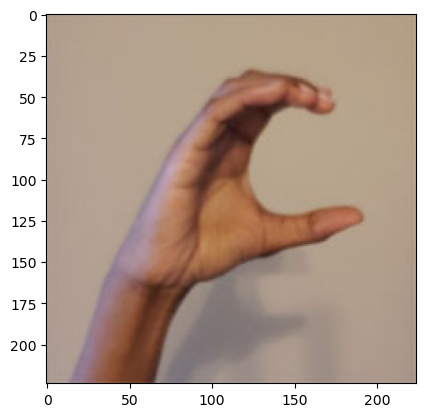

torch.Size([3, 224, 224])
3


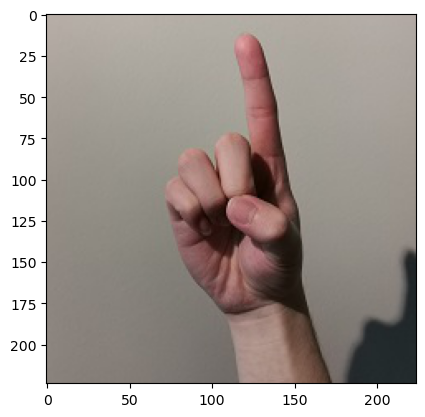

torch.Size([3, 224, 224])
3


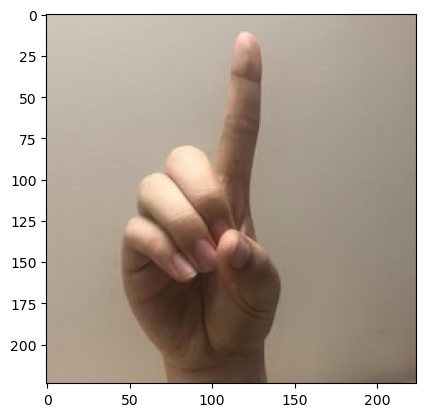

torch.Size([3, 224, 224])
4


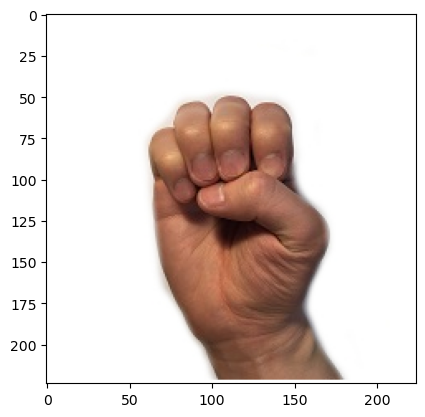

torch.Size([3, 224, 224])
5


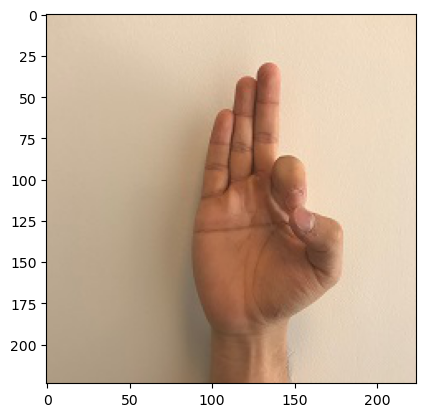

torch.Size([3, 224, 224])
5


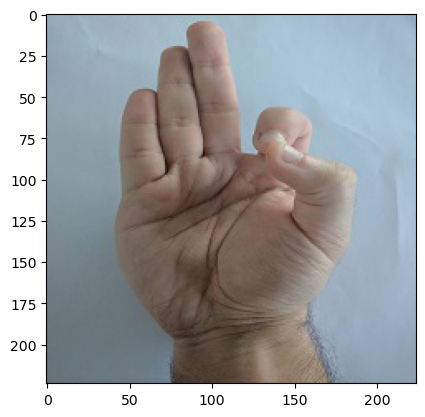

torch.Size([3, 224, 224])
6


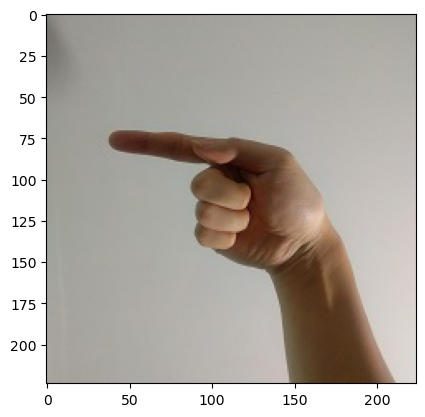

torch.Size([3, 224, 224])
6


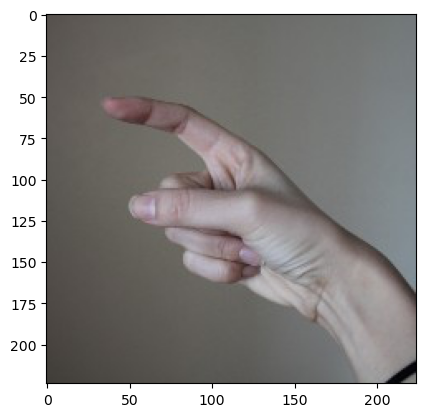

torch.Size([3, 224, 224])
7


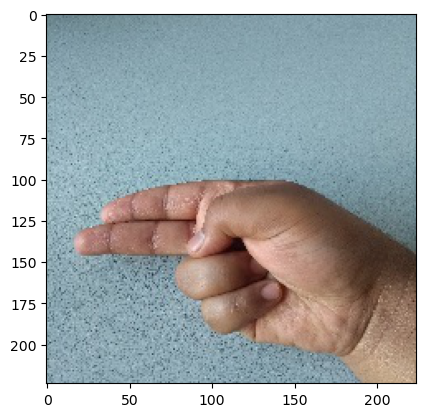

torch.Size([3, 224, 224])
8


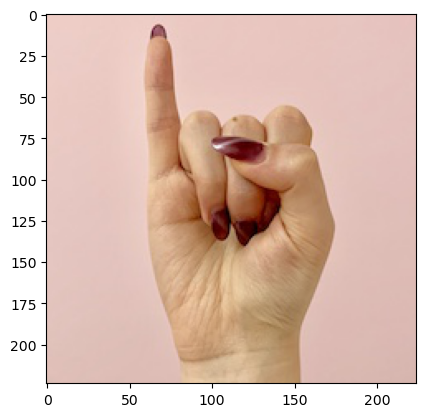

torch.Size([3, 224, 224])
8


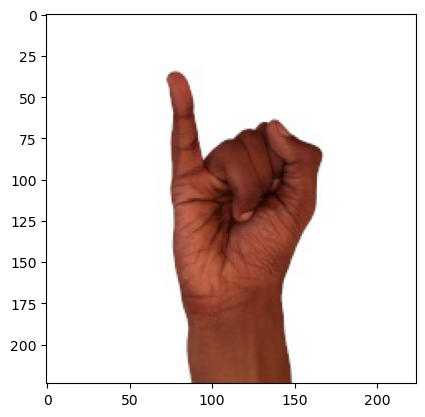

In [4]:
c = 0
for x, y in train_data:
    if c % 50 == 0:
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        plt.show()
    c += 1
    

The variable `x` contains the (224x224) RGB values of an image (hand signal that corresponds to a single letter in ASL). t is of shape [3,224,224], i..e. 3 arrays of the RGB values for that image.

The variable `y` contains the label of the input x, i.e. a single integer representing the letter that the image in `x` corresponds to: so 0 represents 'A', 1 represents 'B' and so on.

PyTorch generated these labels from the folder structure by taking the index (in the file structure) of the folder corresponding to the input x.

We can create minibatches with our data by using the DataLoader helper in PyTorch

In [5]:
import torch

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([10, 3, 224, 224])
tensor([2, 8, 4, 1, 2, 6, 3, 7, 0, 3])


The variable `x` is a minibatch of 10 inputs, each input is an image showing a sign representing a single letter in ASL. The images are 3 by 224 by 224, 3 color dimensions and 224 by 224 pixels, so x is of shape [10,3,224,224] (10 RGB images of size 224 by 224).

`y` is a list of integers, each representing the letter its associated element in `x` shows in ASL, so if the image in `x[1]` represents the letter 'g', the value stored in `y[1]` will be 6, as 'g' is the seventh letter of the alphabet. So `y` is a list of length 10.


In [7]:
print("Training Data: {}".format(len(train_data)))
print("Validation Data: {}".format(len(valid_data)))
print("Test Data: {}".format(len(test_data)))

Training Data: 733
Validation Data: 207
Test Data: 223


- There are 733 images in the training set
- There are 207 images in the validation set
- There are 223 images in the test set

### II. MODEL BUILDING

First, we will build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the letter.

Architecture:

- 4 convolutional layers with 3x3 kernels.

- Downsampling operations after each convolution layer (Max Pooling)

- In typical convolutional neural network architectures, every time we downsample, we double the number of features (channels). This is so that we don't lose too much information in each layer. We will set the number of output channels in our first convolutional layer to a variable, and double this value in every subsequent convolutions.
This pattern of **doubling the number of channels with every pooling / strided convolution** is common in modern convolutional architectures.
It is used to avoid loss of too much information within a single reduction in resolution.

- 2 fully-connected layers as final layers - Typical CNNS will have a few (1-3) fully-connected layers as the final layers.

We will also build 3 other networks following the same architecture but adding a few different layers to study their effect:

- Adding batch normalization layer after 2 convolutions

- Adding dropout layers

- Adding both batch normalization and dropout layers


In [8]:
import torch.nn as nn

- Model 1: CNN with architecture described above

In [30]:
class CNN_1(nn.Module):
    def __init__(self, channels = 8, hidden_layers=100):
        super(CNN_1, self).__init__()
        # in_channels is 3 since we have 3 sets of values for RGB
        self.channels = channels
        # Initial image Size: 3 x 224 x 224 = 15 0528
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1)
        # After Conv 1: outchannels x 224 x 224 --> 8 x 224 x 224
        self.pool1 = nn.MaxPool2d(2, 2)
        # After Pooling: 8 x 112 x 112 = 10 0352

        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, padding=1)
        # After Conv 2: 16 x 112 x 112
        self.pool2 = nn.MaxPool2d(2, 2)
        # After Pooling: 16 x 56 x 56 = 5 0176

        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*2*2, kernel_size=3, padding=1)
        # After Conv 3: 32 x 56 x 56
        self.pool3 = nn.MaxPool2d(2, 2)
        # After Pooling: 32 x 28 x 28 = 2 5088

        # self.conv4 = nn.Conv2d(in_channels=channels*2*2, out_channels=channels*2*2*2, kernel_size=3, padding=1)
        # # After Conv 4: 64 x 28 x 28
        # self.pool4 = nn.MaxPool2d(2, 2)
        # # After Pooling: 64 x 14 x 14 = 1 2544

        # Two Fully Connected layers
        #self.fc1 = nn.Linear((channels*2*2*2) * 14*14, hidden_layers)
        self.fc1 = nn.Linear((channels*2*2) * 28*28, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, 9)

    def forward(self, x):
        #print(x.shape)

        x = self.pool1(torch.relu(self.conv1(x))) # Conv 1 and Pool 1
        #print(x.shape)

        x = self.pool2(torch.relu(self.conv2(x))) # Conv 2 and Pool 2
        #print(x.shape)

        x = self.pool3(torch.relu(self.conv3(x))) # Conv 3 and Pool 3
        #print(x.shape)

        # x=self.pool4(torch.relu(self.conv4(x))) # Conv 4 and Pool 4
        #print(x.shape)

        # x = x.view(-1, (self.channels*2*2*2) * 14*14)
        x = x.view(-1, (self.channels*2*2) * 28*28)
        #print(x.shape)

        x = torch.relu(self.fc1(x))
        #print(x.shape)

        x = self.fc2(x)
        #print(x.shape)

        return x

In [31]:
test_model1 = CNN_1()
test_model1

CNN_1(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)

- Model 2: Variation of CNN 1 with batch normalization layers after convolutions 1 and 3

Batch Normalization (BN) is a technique used in deep learning to improve the performance of neural networks. In a Convolutional Neural Network (CNN), the BN layer is added after the convolutional layer and before the activation function.

The main idea behind batch normalization is to normalize the inputs to a layer in such a way that the mean and variance of the inputs are approximately constant. This has the effect of reducing the internal covariate shift, which is the change in the distribution of the inputs to a layer caused by the changing parameters of the previous layers.

The BN layer normalizes the inputs by subtracting the mean and dividing by the standard deviation of the inputs in a mini-batch. The normalized values are then scaled and shifted using learned parameters, so that the output of the BN layer can represent a non-linear function of the input. This normalization process helps to stabilize the distribution of the inputs to the activation function, which can help to **speed up training** and **improve the accuracy** of the network.

It does not make sense to add the batch normalization or dropout layer as
our *final* layer: 

For our final layer we end up with values for the 9 letters. To do either batch normalization or droupout layer here would not actually change which value is the max among them. As such, it is of little use to apply it there since it would not change our model's final prediction.


In [39]:
class CNN_2(nn.Module):
    def __init__(self, channels = 8, hidden_layers=100):
        super(CNN_2, self).__init__()
        # in_channels is 3 since we have 3 sets of values for RGB
        self.channels = channels
        # Initial image Size: 3 x 224 x 224 = 15 0528

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1)
        # After Conv 1: outchannels x 224 x 224 --> 8 x 224 x 224

        self.conv1_bn=nn.BatchNorm2d(channels) # Added batch normalization

        self.pool1 = nn.MaxPool2d(2, 2)
        # After Pooling: 8 x 112 x 112 = 10 0352

        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, padding=1)
        # After Conv 2: 16 x 112 x 112
        self.pool2 = nn.MaxPool2d(2, 2)
        # After Pooling: 16 x 56 x 56 = 5 0176

        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*2*2, kernel_size=3, padding=1)
        # After Conv 3: 32 x 56 x 56

        self.conv3_bn=nn.BatchNorm2d(channels*2*2) # Added batch norm

        self.pool3 = nn.MaxPool2d(2, 2)
        # After Pooling: 32 x 28 x 28 = 2 5088

        # self.conv4 = nn.Conv2d(in_channels=channels*2*2, out_channels=channels*2*2*2, kernel_size=3, padding=1)
        # # After Conv 4: 64 x 28 x 28
        # self.pool4 = nn.MaxPool2d(2, 2)
        # # After Pooling: 64 x 14 x 14 = 1 2544

        # Two Fully Connected layers
        # self.fc1 = nn.Linear((channels*2*2*2) * 14*14, hidden_layers)
        self.fc1 = nn.Linear((channels*2*2) * 28*28, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, 9)

    def forward(self, x):
        #print(x.shape)

        x = self.pool1(torch.relu(self.conv1_bn(self.conv1(x)))) # Conv 1 and Pool 1
        #print(x.shape)

        x = self.pool2(torch.relu(self.conv2(x))) # Conv 2 and Pool 2
        #print(x.shape)

        x = self.pool3(torch.relu(self.conv3_bn(self.conv3(x)))) # Conv 3 and Pool 3
        #print(x.shape)

        # x=self.pool4(torch.relu(self.conv4(x))) # Conv 4 and Pool 4
        #print(x.shape)

        # x = x.view(-1, (self.channels*2*2*2) * 14*14)
        x = x.view(-1, (self.channels*2*2) * 28*28)
        #print(x.shape)

        x = torch.relu(self.fc1(x))
        #print(x.shape)

        x = self.fc2(x)
        #print(x.shape)

        return x

In [40]:
test_model2 = CNN_2()
print(test_model2)

CNN_2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)


- Model 3: Variation of CNN 1 using 2 dropout layers after convolution 4 and fully connected layer 1

Dropout is a regularization technique that is widely used in deep learning to prevent overfitting. A dropout layer is a layer that randomly drops out a fraction of the inputs to a layer during training. The idea is that by randomly dropping out some inputs, the network is forced to learn more robust features and prevent overfitting to the training data.

In a dropout layer, a dropout rate is specified, which is the probability of dropping out each input (p). During training, each input is randomly dropped out with a probability equal to the dropout rate. The remaining inputs are scaled up by a factor of 1/(1 - dropout rate) to compensate for the dropped out inputs.

In [42]:
class CNN_3(nn.Module):
    def __init__(self, channels = 8, hidden_layers=100):
        super(CNN_3, self).__init__()
        # in_channels is 3 since we have 3 sets of values for RGB
        self.channels = channels
        # Initial image Size: 3 x 224 x 224 = 15 0528
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1)
        # After Conv 1: outchannels x 224 x 224 --> 8 x 224 x 224
        self.pool1 = nn.MaxPool2d(2, 2)
        # After Pooling: 8 x 112 x 112 = 10 0352

        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, padding=1)
        # After Conv 2: 16 x 112 x 112

        self.dropout1 = nn.Dropout(p=0.5)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        # After Pooling: 16 x 56 x 56 = 5 0176

        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*2*2, kernel_size=3, padding=1)
        # After Conv 3: 32 x 56 x 56

        self.dropout2 = nn.Dropout(p=0.5)

        self.pool3 = nn.MaxPool2d(2, 2)
        # After Pooling: 32 x 28 x 28 = 2 5088

        # self.conv4 = nn.Conv2d(in_channels=channels*2*2, out_channels=channels*2*2*2, kernel_size=3, padding=1)
        # # After Conv 4: 64 x 28 x 28

        # self.dropout2 = nn.Dropout(p=0.2)

        # self.pool4 = nn.MaxPool2d(2, 2)
        # After Pooling: 64 x 14 x 14 = 1 2544

        # Two Fully Connected layers
        # self.fc1 = nn.Linear((channels*2*2*2) * 14*14, hidden_layers)
        self.fc1 = nn.Linear((channels*2*2) * 28*28, hidden_layers)
    
        self.fc2 = nn.Linear(hidden_layers, 9)

    def forward(self, x):
        #print(x.shape)

        x = self.pool1(torch.relu(self.conv1(x))) # Conv 1 and Pool 1
        #print(x.shape)

        x = self.pool2(torch.relu(self.dropout1(self.conv2(x)))) # Conv 2 and Pool 2
        #print(x.shape)

        x = self.pool3(torch.relu(self.dropout2(self.conv3(x)))) # Conv 3 and Pool 3
        #print(x.shape)

        # x=self.pool4(torch.relu(self.dropout2(self.conv4(x)))) # Conv 4 and Pool 4
        #print(x.shape)

        # x = x.view(-1, (self.channels*2*2*2) * 14*14)
        x = x.view(-1, (self.channels*2*2) * 28*28)
        #print(x.shape)

        x = torch.relu(self.fc1(x))
        #print(x.shape)

        x = self.fc2(x)
        #print(x.shape)

        return x

In [43]:
test_model3 = CNN_3()
print(test_model3)

CNN_3(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.5, inplace=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)


- Model 4: Variation of CNN 1 by combining CNNs 1 and 2 together: Adding batch normalization after convolutions 1 and 3 and dropout layers after convolution 4 and fully connected layer 1

It is common to use both dropout and batch normalization layers in a CNN. In fact, using both techniques together can often improve the performance of the network.

Batch normalization helps to reduce internal covariate shift and speed up training, while dropout helps to prevent overfitting and improve the robustness of the learned features. By using both techniques together, the network can benefit from the advantages of both techniques.


In [44]:
class CNN_4(nn.Module):
    def __init__(self, channels = 8, hidden_layers=100):
        super(CNN_4, self).__init__()
        # in_channels is 3 since we have 3 sets of values for RGB
        self.channels = channels
        # Initial image Size: 3 x 224 x 224 = 15 0528

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding=1)
        # After Conv 1: outchannels x 224 x 224 --> 8 x 224 x 224

        self.conv1_bn=nn.BatchNorm2d(channels) # Added batch normalization

        self.pool1 = nn.MaxPool2d(2, 2)
        # After Pooling: 8 x 112 x 112 = 10 0352

        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, padding=1)
        # After Conv 2: 16 x 112 x 112

        self.dropout1 = nn.Dropout(p=0.5)

        self.pool2 = nn.MaxPool2d(2, 2)
        # After Pooling: 16 x 56 x 56 = 5 0176

        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*2*2, kernel_size=3, padding=1)
        # After Conv 3: 32 x 56 x 56

        self.conv3_bn=nn.BatchNorm2d(channels*2*2) # Added batch norm

        self.pool3 = nn.MaxPool2d(2, 2)
        # After Pooling: 32 x 28 x 28 = 2 5088

        # self.conv4 = nn.Conv2d(in_channels=channels*2*2, out_channels=channels*2*2*2, kernel_size=3, padding=1)
        # # After Conv 4: 64 x 28 x 28
        
        # self.dropout2 = nn.Dropout(p=0.2)

        # self.pool4 = nn.MaxPool2d(2, 2)
        # After Pooling: 64 x 14 x 14 = 1 2544

        # Two Fully Connected layers
        # self.fc1 = nn.Linear((channels*2*2*2) * 14*14, hidden_layers)
        self.fc1 = nn.Linear((channels*2*2) * 28*28, hidden_layers)

        self.fc2 = nn.Linear(hidden_layers, 9)

    def forward(self, x):
        #print(x.shape)

        x = self.pool1(torch.relu(self.conv1_bn(self.conv1(x)))) # Conv 1 and Pool 1
        #print(x.shape)

        x = self.pool2(torch.relu(self.dropout1(self.conv2(x)))) # Conv 2 and Pool 2
        #print(x.shape)

        x = self.pool3(torch.relu(self.conv3_bn(self.conv3(x)))) # Conv 3 and Pool 3
        #print(x.shape)

        # x = self.pool4(torch.relu(self.dropout2(self.conv4(x)))) # Conv 4 and Pool 4
        #print(x.shape)

        # x = x.view(-1, (self.channels*2*2*2) * 14*14)
        x = x.view(-1, (self.channels*2*2) * 28*28)
        #print(x.shape)

        x = torch.relu(self.fc1(x))
        #print(x.shape)

        x = self.fc2(x)
        #print(x.shape)

        return x

In [45]:
test_model4 = CNN_4()
print(test_model4)

CNN_4(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)


### III. TRAINING CODE AND SANITY CHECKING

First , we implement a `get_accuracy` function, which computes the model accuracy across a dataset:

In [46]:
def get_accuracy(model, data):
    '''
    Compute accuracy of a model given a labeled dataset of images.
    '''
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.eval() # Annotate model for evaluation

    correct, total = 0, 0
    for imgs, labels in loader:
        output = model(imgs) # No need for torch.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    
    return correct/total

In [47]:
get_accuracy(test_model1, train_data)

0.11732605729877217

In [48]:
get_accuracy(test_model2, train_data)

0.10368349249658936

In [49]:
get_accuracy(test_model3, train_data)

0.11323328785811733

In [50]:
get_accuracy(test_model4, train_data)

0.11732605729877217

Now, we can write code to train our neural network given some training data. 
We will make it so that it is easy to tweak hyperparameters.
We will also be checkpointing frequently.

Here is a quick outline of how we will be implementing:

- use the data loader to load the training data
- use Cross Entropy (???) loss function 
- use Adam, SGD (???) optimizer
- Shuffling training data at the start of each epoch
- in each iteration, take `batch_size` samples from the data set
- use the correct labels from the data set
- computing the forward and backward passes
- after every epoch, **checkpoint our model**
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and **plot the training curve**
- correctly handling edge cases (the last batch be smaller than the rest)

In [51]:
import torch.optim as optim

In [89]:
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=10, optimizer="adam", checkpoint_path=None):
    '''
    Trains model given training data and hyperparameters
    '''
    # Cross-Entropy Loss
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    assert optimizer in ("sgd, adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Track Learning Curve Info
    iters, losses, train_acc, val_acc = [], [], [], []

    ## Training
    n=0
    for epoch in range(num_epochs):
        # Loading training data and shuffling at start of epoch
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        for imgs, labels in iter(train_loader):
            real_batch_size = batch_size
            if imgs.size()[0] < batch_size:
                # Last batch might be smaller than the rest
                real_batch_size = imgs.size()[0]
            # Annotate model for training
            model.train()
            # Forward propagation
            out = model(imgs)
            # Compute Loss
            loss = criterion(out, labels)
            # Backward propagation
            loss.backward()
            # Optimizer Cleanup
            optimizer.step()
            optimizer.zero_grad()
            # Save current training info
            iters.append(n)
            losses.append(float(loss)/real_batch_size)
            train_acc.append(get_accuracy(model, train_data))
            val_acc.append(get_accuracy(model, valid_data))
            # Update iteration number
            n+=1
        # Checkpointing and printing info every 2 epochs
        if epoch % 1 == 0:
        #if n % 10 == 0:
            print("Epoch %d. Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      epoch, n, val_acc[-1] * 100, train_acc[-1] * 100, losses[-1]))
            if(checkpoint_path is not None) and n > 0:
                torch.save(model.state_dict(), checkpoint_path.format(n))

    ## Plotting
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1] * 100))
    print("Final Validation Accuracy: {}".format(val_acc[-1] * 100))

One way to sanity check our neural network model and training code is to check whether each of our models is capable of "memorizing" or "overfitting" to a small dataset. 

We have constructed a small dataset (2 image per class) to show that our models and training code are capable of overfitting on this small dataset. 

If everything is correct, we should be able to obtain a 100% 
training accuracy on that small dataset relatively quickly (i.e. within a few hundred iterations, possibly more depending on our learning rate).

In [53]:
small_path = "asl_data/small/"
small_data = torchvision.datasets.ImageFolder(small_path, transform=torchvision.transforms.ToTensor())

Epoch 9. Iter 10. [Val Acc 67%] [Train Acc 67%, Loss 0.103411]
Epoch 19. Iter 20. [Val Acc 100%] [Train Acc 100%, Loss 0.024554]
Epoch 29. Iter 30. [Val Acc 100%] [Train Acc 100%, Loss 0.000680]
Epoch 39. Iter 40. [Val Acc 100%] [Train Acc 100%, Loss 0.000062]
Epoch 49. Iter 50. [Val Acc 100%] [Train Acc 100%, Loss 0.000010]
Epoch 59. Iter 60. [Val Acc 100%] [Train Acc 100%, Loss 0.000002]
Epoch 69. Iter 70. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]
Epoch 79. Iter 80. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]
Epoch 89. Iter 90. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]
Epoch 99. Iter 100. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]


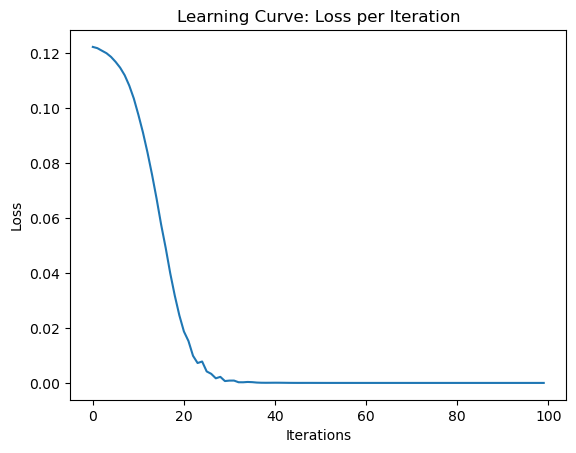

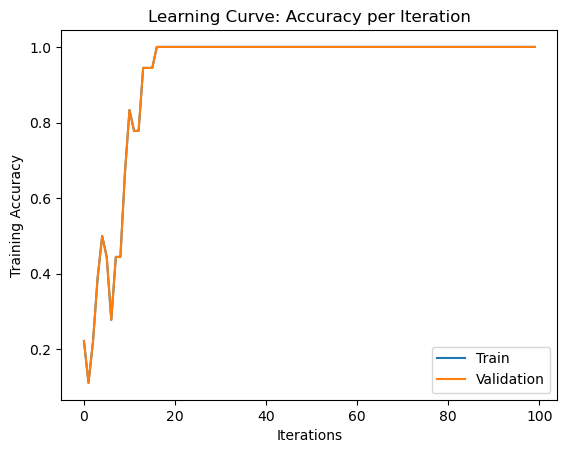

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0


In [58]:
net_1_small = CNN_1(channels=8, hidden_layers=100)
train(net_1_small, small_data, small_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=100, optimizer="adam", checkpoint_path=None)

Epoch 9. Iter 10. [Val Acc 11%] [Train Acc 11%, Loss 0.000268]
Epoch 19. Iter 20. [Val Acc 61%] [Train Acc 61%, Loss 0.000032]
Epoch 29. Iter 30. [Val Acc 100%] [Train Acc 100%, Loss 0.000003]
Epoch 39. Iter 40. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]
Epoch 49. Iter 50. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 59. Iter 60. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 69. Iter 70. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 79. Iter 80. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 89. Iter 90. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 99. Iter 100. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]


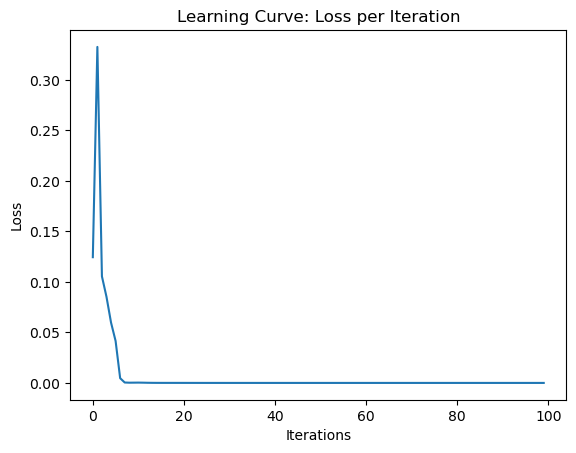

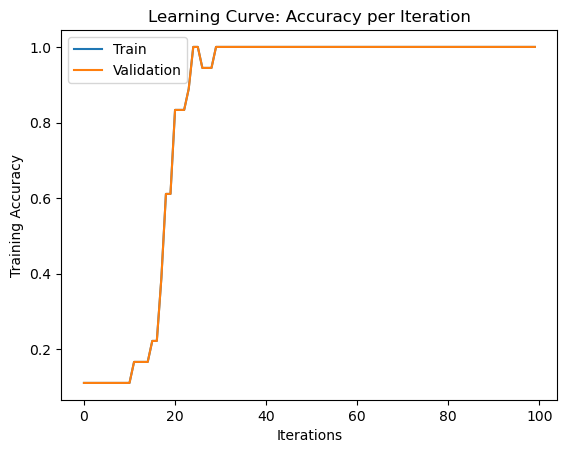

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0


In [55]:
net2_small = CNN_2(channels=8, hidden_layers=100)
train(net2_small, small_data, small_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=100, optimizer="adam", checkpoint_path=None)

Epoch 9. Iter 10. [Val Acc 28%] [Train Acc 28%, Loss 0.118930]
Epoch 19. Iter 20. [Val Acc 83%] [Train Acc 83%, Loss 0.073058]
Epoch 29. Iter 30. [Val Acc 100%] [Train Acc 100%, Loss 0.001366]
Epoch 39. Iter 40. [Val Acc 100%] [Train Acc 100%, Loss 0.000008]
Epoch 49. Iter 50. [Val Acc 100%] [Train Acc 100%, Loss 0.000001]
Epoch 59. Iter 60. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 69. Iter 70. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 79. Iter 80. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 89. Iter 90. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 99. Iter 100. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]


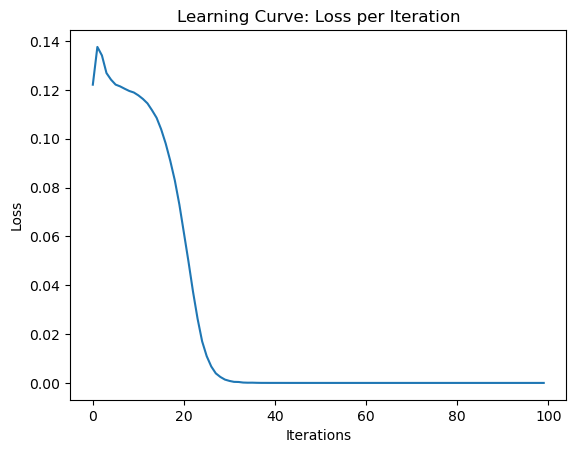

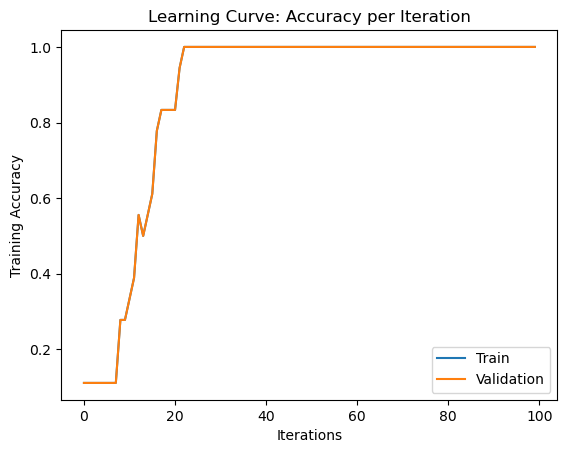

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0


In [56]:
net_3_small = CNN_3(channels=8, hidden_layers=100)
train(net_3_small, small_data, small_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=100, optimizer="adam", checkpoint_path=None)

Epoch 9. Iter 10. [Val Acc 11%] [Train Acc 11%, Loss 0.001814]
Epoch 19. Iter 20. [Val Acc 22%] [Train Acc 22%, Loss 0.000110]
Epoch 29. Iter 30. [Val Acc 56%] [Train Acc 56%, Loss 0.000003]
Epoch 39. Iter 40. [Val Acc 56%] [Train Acc 56%, Loss 0.000001]
Epoch 49. Iter 50. [Val Acc 78%] [Train Acc 78%, Loss 0.000001]
Epoch 59. Iter 60. [Val Acc 94%] [Train Acc 94%, Loss 0.000000]
Epoch 69. Iter 70. [Val Acc 94%] [Train Acc 94%, Loss 0.000000]
Epoch 79. Iter 80. [Val Acc 94%] [Train Acc 94%, Loss 0.000000]
Epoch 89. Iter 90. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]
Epoch 99. Iter 100. [Val Acc 100%] [Train Acc 100%, Loss 0.000000]


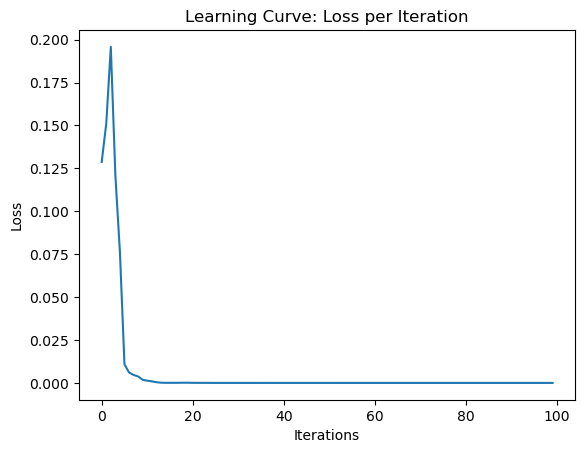

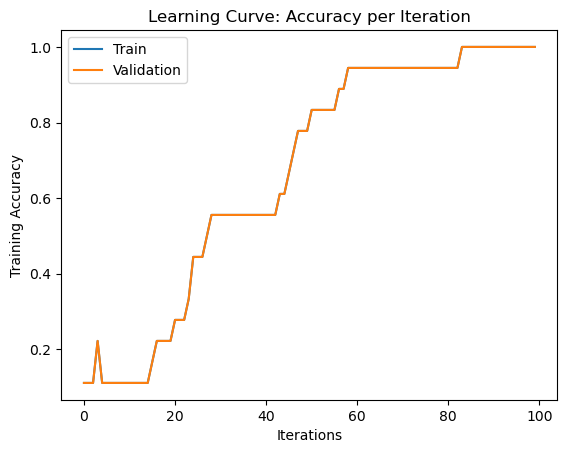

Final Training Accuracy: 100.0
Final Validation Accuracy: 100.0


In [57]:
net_4_small = CNN_4(channels=8, hidden_layers=100)
train(net_4_small, small_data, small_data, batch_size=32, weight_decay=0.0, learning_rate=0.001, num_epochs=100, optimizer="adam", checkpoint_path=None)

### IV. TRAINING

Now we will train our two networks on the training set

Epoch 0. Iter 12. [Val Acc 12%] [Train Acc 11%, Loss 0.075169]
Epoch 2. Iter 36. [Val Acc 46%] [Train Acc 38%, Loss 0.069003]
Epoch 4. Iter 60. [Val Acc 60%] [Train Acc 54%, Loss 0.053783]
Epoch 6. Iter 84. [Val Acc 71%] [Train Acc 76%, Loss 0.030356]
Epoch 8. Iter 108. [Val Acc 72%] [Train Acc 87%, Loss 0.017119]
Epoch 10. Iter 132. [Val Acc 77%] [Train Acc 90%, Loss 0.020906]
Epoch 12. Iter 156. [Val Acc 71%] [Train Acc 90%, Loss 0.016879]
Epoch 14. Iter 180. [Val Acc 75%] [Train Acc 95%, Loss 0.005473]
Epoch 16. Iter 204. [Val Acc 76%] [Train Acc 97%, Loss 0.002498]
Epoch 18. Iter 228. [Val Acc 76%] [Train Acc 98%, Loss 0.001215]
Epoch 20. Iter 252. [Val Acc 78%] [Train Acc 100%, Loss 0.002409]
Epoch 22. Iter 276. [Val Acc 77%] [Train Acc 100%, Loss 0.000222]
Epoch 24. Iter 300. [Val Acc 77%] [Train Acc 100%, Loss 0.000487]
Epoch 26. Iter 324. [Val Acc 78%] [Train Acc 100%, Loss 0.000567]
Epoch 28. Iter 348. [Val Acc 78%] [Train Acc 100%, Loss 0.000122]


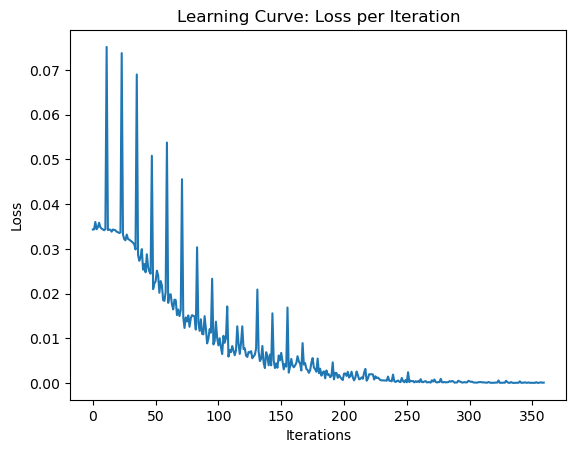

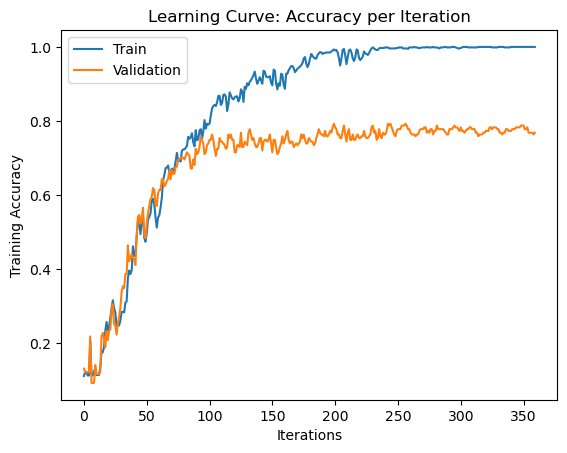

Final Training Accuracy: 100.0
Final Validation Accuracy: 76.81159420289855


In [60]:
net_1 = CNN_1(channels=8, hidden_layers=100)
train(net_1, train_data, valid_data, batch_size=64, weight_decay=0.0, learning_rate=0.001, num_epochs=30, optimizer="adam", checkpoint_path="model_ckpts/model1/ckpt-{}.pk")

Epoch 0. Iter 12. [Val Acc 17%] [Train Acc 18%, Loss 0.111675]
Epoch 2. Iter 36. [Val Acc 39%] [Train Acc 42%, Loss 0.026539]
Epoch 4. Iter 60. [Val Acc 60%] [Train Acc 76%, Loss 0.017603]
Epoch 6. Iter 84. [Val Acc 75%] [Train Acc 97%, Loss 0.003940]
Epoch 8. Iter 108. [Val Acc 74%] [Train Acc 100%, Loss 0.003144]
Epoch 10. Iter 132. [Val Acc 76%] [Train Acc 100%, Loss 0.001757]
Epoch 12. Iter 156. [Val Acc 76%] [Train Acc 100%, Loss 0.001045]
Epoch 14. Iter 180. [Val Acc 77%] [Train Acc 100%, Loss 0.000635]
Epoch 16. Iter 204. [Val Acc 77%] [Train Acc 100%, Loss 0.000465]
Epoch 18. Iter 228. [Val Acc 79%] [Train Acc 100%, Loss 0.000267]
Epoch 20. Iter 252. [Val Acc 78%] [Train Acc 100%, Loss 0.000155]
Epoch 22. Iter 276. [Val Acc 77%] [Train Acc 100%, Loss 0.000234]
Epoch 24. Iter 300. [Val Acc 78%] [Train Acc 100%, Loss 0.000114]
Epoch 26. Iter 324. [Val Acc 77%] [Train Acc 100%, Loss 0.000226]
Epoch 28. Iter 348. [Val Acc 77%] [Train Acc 100%, Loss 0.000198]


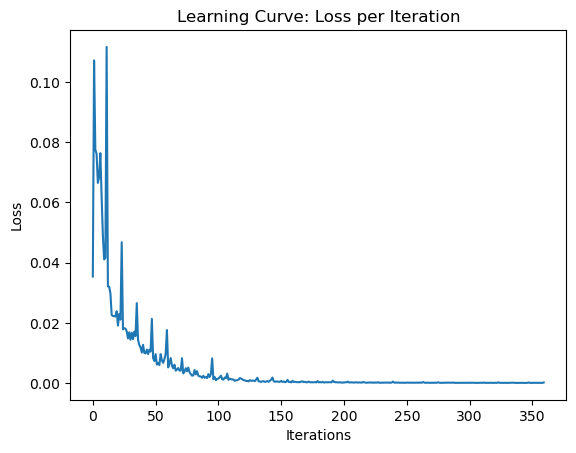

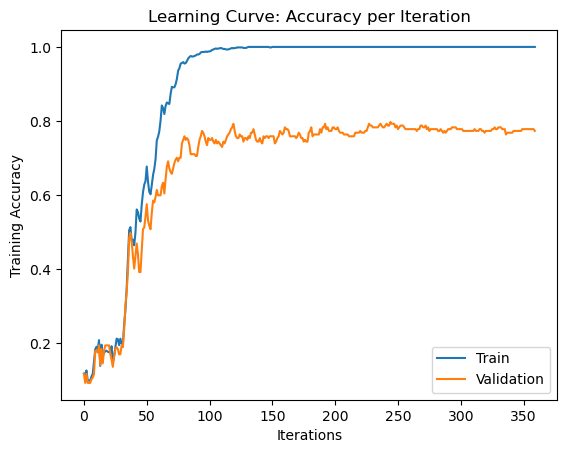

Final Training Accuracy: 100.0
Final Validation Accuracy: 77.29468599033817


In [61]:
net_2 = CNN_2(channels=8, hidden_layers=100)
train(net_2, train_data, valid_data, batch_size=64, weight_decay=0.0, learning_rate=0.001, num_epochs=30, optimizer="adam", checkpoint_path="model_ckpts/model2/ckpt-{}.pk")

Epoch 0. Iter 12. [Val Acc 12%] [Train Acc 13%, Loss 0.075767]
Epoch 2. Iter 36. [Val Acc 22%] [Train Acc 21%, Loss 0.073869]
Epoch 4. Iter 60. [Val Acc 35%] [Train Acc 34%, Loss 0.056422]
Epoch 6. Iter 84. [Val Acc 62%] [Train Acc 63%, Loss 0.041690]
Epoch 8. Iter 108. [Val Acc 65%] [Train Acc 70%, Loss 0.021173]
Epoch 10. Iter 132. [Val Acc 69%] [Train Acc 65%, Loss 0.033305]
Epoch 12. Iter 156. [Val Acc 71%] [Train Acc 75%, Loss 0.024357]
Epoch 14. Iter 180. [Val Acc 77%] [Train Acc 81%, Loss 0.029103]
Epoch 16. Iter 204. [Val Acc 75%] [Train Acc 81%, Loss 0.018048]
Epoch 18. Iter 228. [Val Acc 72%] [Train Acc 87%, Loss 0.017384]
Epoch 20. Iter 252. [Val Acc 77%] [Train Acc 87%, Loss 0.011062]
Epoch 22. Iter 276. [Val Acc 78%] [Train Acc 89%, Loss 0.012762]
Epoch 24. Iter 300. [Val Acc 77%] [Train Acc 93%, Loss 0.009635]
Epoch 26. Iter 324. [Val Acc 78%] [Train Acc 95%, Loss 0.016472]
Epoch 28. Iter 348. [Val Acc 75%] [Train Acc 92%, Loss 0.009838]


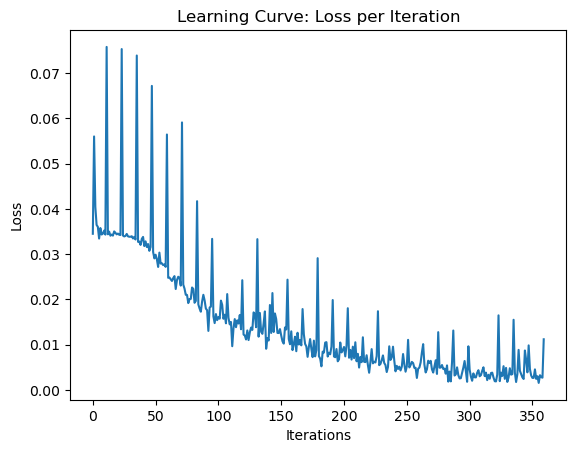

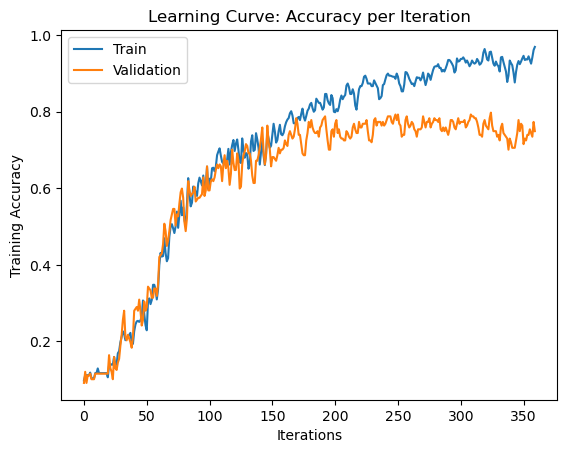

Final Training Accuracy: 96.86221009549796
Final Validation Accuracy: 74.8792270531401


In [62]:
net_3 = CNN_3(channels=8, hidden_layers=100)
train(net_3, train_data, valid_data, batch_size=64, weight_decay=0.0, learning_rate=0.001, num_epochs=30, optimizer="adam", checkpoint_path="model_ckpts/model3/ckpt-{}.pk")

Epoch 0. Iter 12. [Val Acc 18%] [Train Acc 15%, Loss 0.104543]
Epoch 2. Iter 36. [Val Acc 20%] [Train Acc 22%, Loss 0.069385]
Epoch 4. Iter 60. [Val Acc 45%] [Train Acc 47%, Loss 0.059771]
Epoch 6. Iter 84. [Val Acc 49%] [Train Acc 56%, Loss 0.041841]
Epoch 8. Iter 108. [Val Acc 53%] [Train Acc 62%, Loss 0.038282]
Epoch 10. Iter 132. [Val Acc 57%] [Train Acc 65%, Loss 0.015543]
Epoch 12. Iter 156. [Val Acc 52%] [Train Acc 66%, Loss 0.016824]
Epoch 14. Iter 180. [Val Acc 52%] [Train Acc 70%, Loss 0.016674]
Epoch 16. Iter 204. [Val Acc 59%] [Train Acc 81%, Loss 0.009193]
Epoch 18. Iter 228. [Val Acc 55%] [Train Acc 80%, Loss 0.009052]
Epoch 20. Iter 252. [Val Acc 64%] [Train Acc 92%, Loss 0.002959]
Epoch 22. Iter 276. [Val Acc 56%] [Train Acc 84%, Loss 0.004442]
Epoch 24. Iter 300. [Val Acc 63%] [Train Acc 95%, Loss 0.002122]
Epoch 26. Iter 324. [Val Acc 60%] [Train Acc 89%, Loss 0.001392]
Epoch 28. Iter 348. [Val Acc 65%] [Train Acc 95%, Loss 0.003000]


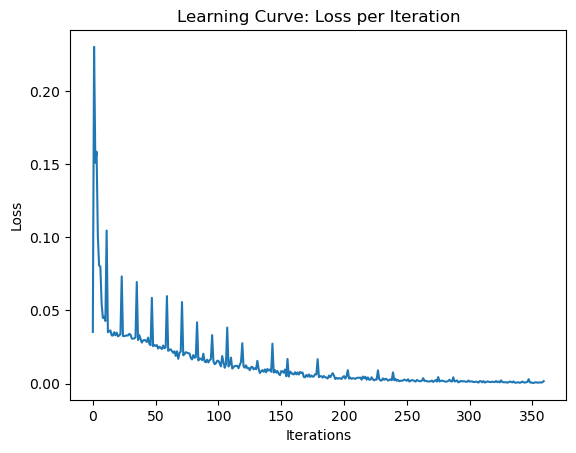

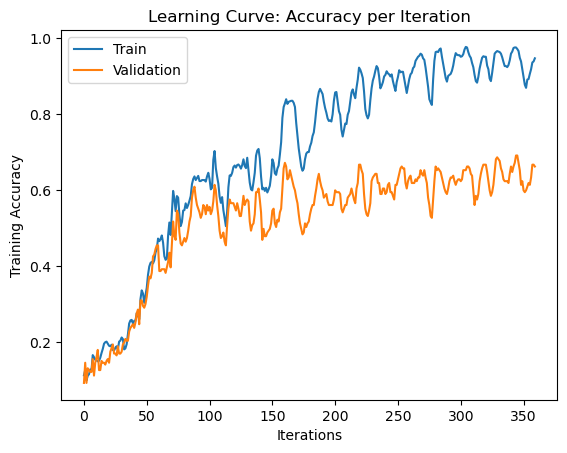

Final Training Accuracy: 94.6793997271487
Final Validation Accuracy: 66.18357487922705


In [65]:
net_4 = CNN_4(channels=8, hidden_layers=100)
train(net_4, train_data, valid_data, batch_size=64, weight_decay=0.0, learning_rate=0.001, num_epochs=30, optimizer="adam", checkpoint_path="model_ckpts/model4/ckpt-{}.pk")

### V. EVALUATING THE NETWORKS

We will calculate the test accuracy for each of the four models

In [74]:
net1_test_acc = get_accuracy(net_1, test_data)
net2_test_acc = get_accuracy(net_2, test_data)
net3_test_acc = get_accuracy(net_3, test_data)
net4_test_acc = get_accuracy(net_4, test_data)

print("Test Accuracy for network 1: ", round(net1_test_acc, 3)*100)
print("Test Accuracy for network 2: ", round(net2_test_acc, 3)*100)
print("Test Accuracy for network 3: ", round(net3_test_acc, 3)*100)
print("Test Accuracy for network 4: ", round(net4_test_acc, 3)*100)

Test Accuracy for network 1:  70.89999999999999
Test Accuracy for network 2:  72.6
Test Accuracy for network 3:  67.30000000000001
Test Accuracy for network 4:  61.0


If we were to select a single set of weight values(checkpoints)
to deploy and use in a real application, we would choose model 2 (with batch normalization) as it had the best test accuracy of all models and would probably have a better performance on unseen data compared to the other models

### VI. TRANSFER LEARNING

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a
similar task to the one you need to solve. This method of using a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**.

We will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

The AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this case.


Here is the code to load the AlexNet network, with pretrained weights.
When we first run the code, PyTorch will download the pretrained weights
from the internet.

In [76]:
import torchvision.models
alexnet = torchvision.models.alexnet(weights=True)

The `alexnet` model is split up into two components: `alexnet.features` and 
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how we can compute the AlexNet
features for some images:

In [77]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

Note that the `.detach()` at the end will be necessary in our code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
gradients. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

We will now compute the AlexNet features for each of our training, validation, and test data.

In other words, we will create three new arrays called `train_data_features`, `valid_data_features`
and `test_data_features`. Each of these arrays will contain tuples of the form 
`(alexnet_features, label)`

In [80]:
train_data_features, test_data_features, valid_data_features = [], [], []

In [87]:
for img, y in train_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    train_data_features.append((features, y),)

for img, y in test_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    test_data_features.append((features, y),)

for img, y in valid_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    valid_data_features.append((features, y),)

Now we will actually build the model. We will create a multi-layer preceptron that
takes **as input** these AlexNet features,
and makes a prediction.

In [88]:
class MLP_TL(nn.Module):
    def __init__(self, hidden_layers=100):
        super(MLP_TL, self).__init__()

        self.fc1 = nn.Linear(256*6*6, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Now we will train the above `MLP` model.

This model should train *much* faster since it has very few parameters.

However, this model should attain much better accuracy much faster!

Epoch 0. Iter 23. [Val Acc 94%] [Train Acc 99%, Loss 0.002339]
Epoch 1. Iter 46. [Val Acc 94%] [Train Acc 100%, Loss 0.000668]
Epoch 2. Iter 69. [Val Acc 96%] [Train Acc 100%, Loss 0.000103]
Epoch 3. Iter 92. [Val Acc 97%] [Train Acc 100%, Loss 0.000106]
Epoch 4. Iter 115. [Val Acc 97%] [Train Acc 100%, Loss 0.000126]
Epoch 5. Iter 138. [Val Acc 97%] [Train Acc 100%, Loss 0.000065]
Epoch 6. Iter 161. [Val Acc 96%] [Train Acc 100%, Loss 0.000074]
Epoch 7. Iter 184. [Val Acc 97%] [Train Acc 100%, Loss 0.000042]


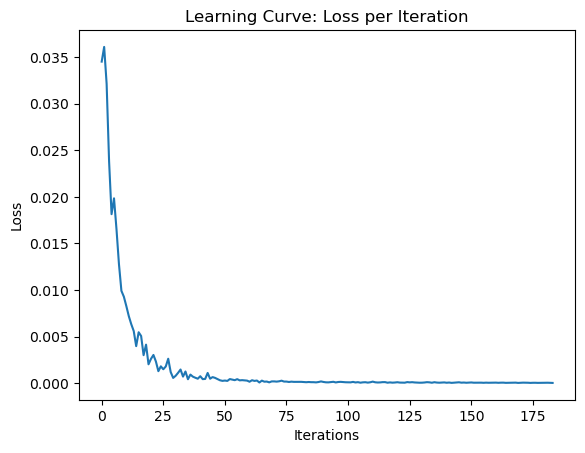

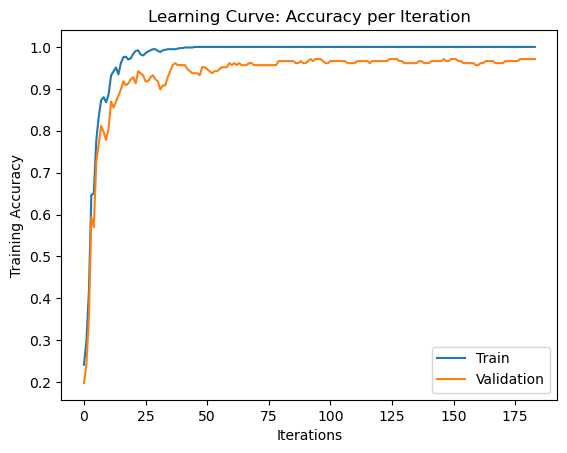

Final Training Accuracy: 100.0
Final Validation Accuracy: 97.10144927536231


In [90]:
net_5 = MLP_TL(hidden_layers=100)
train(net_5, train_data_features, valid_data_features, batch_size=64, weight_decay=0.0, learning_rate=0.001, num_epochs=8, optimizer="adam", checkpoint_path="model_ckpts/model5/ckpt-{}.pk")


Now, we compute the test accuracy

In [92]:
net5_test_acc = get_accuracy(net_5, test_data_features)
print("Test Accuracy for network 5: ", round(net5_test_acc, 3)*100)

Test Accuracy for network 5:  83.39999999999999


Displaying an image that our last model correctly classified:

Prediction:  0
Actual:  0


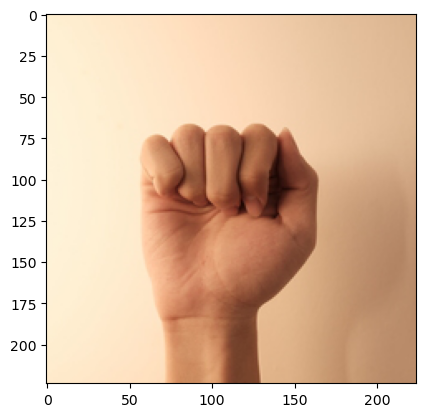

In [98]:
for index, tup in enumerate(test_data_features):
    output = net_5(tup[0])
    pred = output.max(1, keepdim=True)[1]
    if pred == tup[1]:
        plt.imshow(test_data[index][0].permute(1, 2, 0))
        print("Prediction: ", pred.item())
        print("Actual: ", tup[1])
        break

Displaying an image that our last model incorrectly classified:

Prediction:  6
Actual:  0


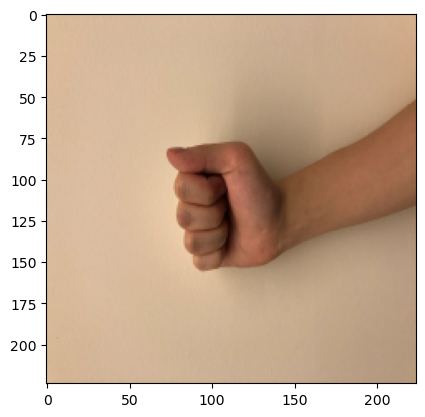

In [101]:
for index, tup in enumerate(test_data_features):
    output = net_5(tup[0])
    pred = output.max(1, keepdim=True)[1]
    if pred != tup[1]:
        plt.imshow(test_data[index][0].permute(1, 2, 0))
        print("Prediction: ", pred.item())
        print("Actual: ", tup[1])
        break

Predicted a G while image is an A